In [ ]:
import tensorflow as sl
print(sl.__version__)

2.15.0


In [ ]:
!pip install gensim
# !wget https://s3.amazonaws.com/GloVe/vectors/glove.6B.100d.txt  # Choose as per requirement

GLOVE emeddings to store the vector representations of words

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2024-04-08 11:08:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-04-08 11:08:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-04-08 11:08:48--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing import sequence
from keras.regularizers import l1,l2
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import *
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
import pickle
from gensim.models import KeyedVectors   # For GloVe Embeddings

glove_path = 'glove.6B.100d.txt'

df = pd.read_csv('preprocessed_data.csv')
X = df['problems']
y = df['entity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['entity'])
tokenizer = Tokenizer(num_words=4000)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)
maxlen = max(len(token) for token in X_train_sequences)
X_train_padded = pad_sequences(X_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=maxlen, padding='post')

# Load GloVe embeddings
embeddings_index = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
vocab = tokenizer.word_index
print(len(vocab))
embedding_dim = 100  # Adjust based on downloaded GloVe file

# Create embedding matrix
embedding_matrix = np.zeros((len(vocab) + 1, embedding_dim))
unknown_embedding = np.mean(embedding_matrix, axis=0)
for word, i in vocab.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
  else:
    embedding_matrix[i] = unknown_embedding

model = Sequential()
model.add(Embedding(len(vocab) + 1, embedding_dim, weights=[embedding_matrix], trainable=False))
model.add(Dropout(0.6))
model.add(Bidirectional(GRU(128,return_sequences=True)))
model.add(BatchNormalization())
model.add(Bidirectional(GRU(128)))
model.add(Dense(26, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

921
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         92200     
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 bidirectional (Bidirection  (None, None, 256)         176640    
 al)                                                             
                                                                 
 batch_normalization (Batch  (None, None, 256)         1024      
 Normalization)                                                  
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                    

In [ ]:
epochs = 25
history = model.fit(X_train_padded, y_train, epochs=epochs, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/25
33/33 [==============================] - 22s 207ms/step - loss: 3.0266 - accuracy: 0.1558 - val_loss: 2.8075 - val_accuracy: 0.4423
Epoch 2/25
33/33 [==============================] - 2s 71ms/step - loss: 2.1057 - accuracy: 0.4500 - val_loss: 2.1618 - val_accuracy: 0.5808
Epoch 3/25
33/33 [==============================] - 3s 81ms/step - loss: 1.5586 - accuracy: 0.5769 - val_loss: 1.6112 - val_accuracy: 0.6731
Epoch 4/25
33/33 [==============================] - 3s 81ms/step - loss: 1.2687 - accuracy: 0.6462 - val_loss: 1.2381 - val_accuracy: 0.7077
Epoch 5/25
33/33 [==============================] - 4s 108ms/step - loss: 1.0089 - accuracy: 0.7115 - val_loss: 0.9265 - val_accuracy: 0.7577
Epoch 6/25
33/33 [==============================] - 5s 152ms/step - loss: 0.8922 - accuracy: 0.7346 - val_loss: 0.8113 - val_accuracy: 0.7500
Epoch 7/25
33/33 [==============================] - 5s 154ms/step - loss: 0.7709 - accuracy: 0.7894 - val_loss: 0.7428 - val_accuracy: 0.7769
Epoch 8/

In [ ]:
# Save the weights, architecture and tokenizer here
model_json = model.to_json()        # Architecture
with open("rudra_wms_gru.json", "w") as json_file:
    json_file.write(model_json)

with open("rudra_wms_gru_tokenizer.pkl", "wb") as handle:   # Tokenizer
    pickle.dump(tokenizer, handle)

model.save_weights("rudra_wms_gru_weights.h5")      # Weights


In [ ]:
model.evaluate(X_test_padded, y_test)

9/9 [==============================] - 0s 37ms/step - loss: 0.5501 - accuracy: 0.8577


[0.5501143336296082, 0.857692301273346]

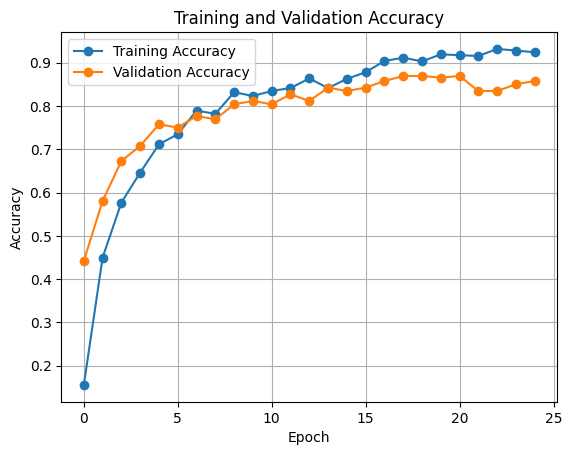

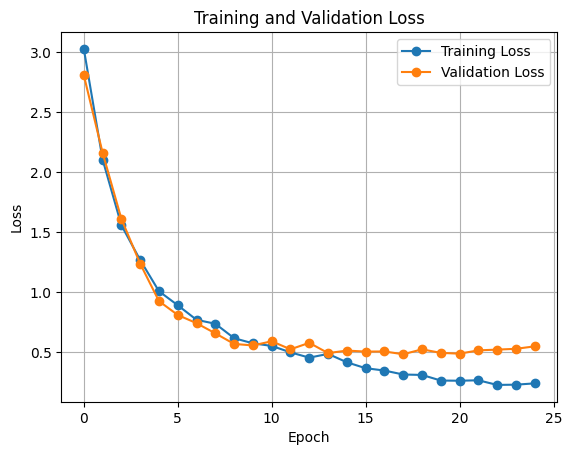

In [ ]:
import matplotlib.pyplot as plt

# Sample data for neural network training history
epochaxis = []
for s in range(epochs):
  epochaxis.append(s)
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy vs. validation accuracy
plt.plot(epochaxis, accuracy, 'o-', label='Training Accuracy')
plt.plot(epochaxis, val_accuracy, 'o-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss vs. validation loss
plt.plot(epochaxis, loss, 'o-', label='Training Loss')
plt.plot(epochaxis, val_loss, 'o-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_json
import numpy as np
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    text = re.sub(r"'\w+", "", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing punctuation and special characters
    tokens = [token for token in tokens if token not in string.punctuation]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


with open("rudra_wms_gru_tokenizer.pkl", "rb") as handle:
    loaded_tokenizer = pickle.load(handle)

input_sentence = "My car brake is not working"
sentence = preprocess_text(input_sentence)
tokenized_sentence = loaded_tokenizer.texts_to_sequences([sentence])[0]
padded_sequence = pad_sequences([tokenized_sentence], maxlen=11, padding='post')


with open("rudra_wms_gru.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("rudra_wms_gru_weights.h5")

prediction = loaded_model.predict(padded_sequence)
predicted_class = np.argmax(prediction[0])
category_names = ['Engine Misfire', 'Overheating', 'Check Engine Light Issues', 'Battery Problems (dead battery, charging issues)', 'Transmission Problems (slipping, rough shifting)', 'Brake Problems (squeaking, grinding, soft brake pedal,worn brake pads)', 'Electrical Issues (faulty wiring, blown fuses)', 'Suspension Problems (bumpy ride, uneven tire wear)', 'Steering Problems (difficulty turning, steering wheel vibration)', 'Fuel System Issues (clogged fuel filter, fuel pump failure)', 'Air Conditioning Problems (not blowing cold air, strange noises)', 'Exhaust System Leaks or Damage', 'Tire Problems (punctures, uneven wear, balding)', 'Cooling System Leaks', 'Ignition System Problems (spark plug issues, ignition coil failure)', 'Emission Control System Faults (Exhaust problems)', 'Oil Leaks (oil changes)', 'Engine Knocking or Pinging', 'Thermostat Issues', 'Radiator Leaks or Blockages', 'Alternator Problems (not charging the battery)', 'Starter Motor Problems (clicking noise, failure to start)', 'Wiper Blade or Wiper Motor Issues', 'Engine Stalling', 'Noisy Engine', 'Rough Idle']
print(f"Problem : {category_names[predicted_class]}")
cnt = 0
for s in prediction:
  if isinstance(s, np.ndarray):
        for prob in s:
            probs = format(float(prob), '.4f')
            print(f"{category_names[cnt]}-->{probs}")
            cnt = cnt + 1


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1/1 [==============================] - 3s 3s/step
Problem : Brake Problems (squeaking, grinding, soft brake pedal,worn brake pads)
Engine Misfire-->0.0004
Overheating-->0.0934
Check Engine Light Issues-->0.0004
Battery Problems (dead battery, charging issues)-->0.0057
Transmission Problems (slipping, rough shifting)-->0.0014
Brake Problems (squeaking, grinding, soft brake pedal,worn brake pads)-->0.5350
Electrical Issues (faulty wiring, blown fuses)-->0.0664
Suspension Problems (bumpy ride, uneven tire wear)-->0.0001
Steering Problems (difficulty turning, steering wheel vibration)-->0.0077
Fuel System Issues (clogged fuel filter, fuel pump failure)-->0.0009
Air Conditioning Problems (not blowing cold air, strange noises)-->0.0022
Exhaust System Leaks or Damage-->0.0001
Tire Problems (punctures, uneven wear, balding)-->0.0001
Cooling System Leaks-->0.0011
Ignition System Problems (spark plug issues, ignition coil failure)-->0.0000
Emission Control System Faults (Exhaust problems)-->0.00

In [ ]:
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.models import model_from_json
import numpy as np
import pickle
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import re

nltk.download('punkt')
nltk.download('stopwords')

def preprocess_text(text):
    # Lowercasing
    text = text.lower()
    text = re.sub(r"'\w+", "", text)

    # Tokenization
    tokens = word_tokenize(text)

    # Removing punctuation and special characters
    tokens = [token for token in tokens if token not in string.punctuation]

    # Removing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Join the tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

input_data = pd.read_csv('input_data.csv')
preprocessed_texts = []
for index, row in input_data.iterrows():
    prepro_text = preprocess_text(row['problems'])
    preprocessed_texts.append(prepro_text)
input_data['problems'] = preprocessed_texts

with open("rudra_wms_gru_tokenizer.pkl", "rb") as handle:
    loaded_tokenizer = pickle.load(handle)
with open("rudra_wms_gru.json", "r") as json_file:
    loaded_model_json = json_file.read()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("rudra_wms_gru_weights.h5")
tokenized_sentences = loaded_tokenizer.texts_to_sequences(input_data['problems'])
padded_sequences = pad_sequences(tokenized_sentences, maxlen=11, padding='post')
predictions = loaded_model.predict(padded_sequences)
predicted_classes = np.argmax(predictions, axis=1)
category_names = ['Engine Misfire', 'Overheating', 'Check Engine Light Issues', 'Battery Problems (dead battery, charging issues)', 'Transmission Problems (slipping, rough shifting)', 'Brake Problems (squeaking, grinding, soft brake pedal,worn brake pads)', 'Electrical Issues (faulty wiring, blown fuses)', 'Suspension Problems (bumpy ride, uneven tire wear)', 'Steering Problems (difficulty turning, steering wheel vibration)', 'Fuel System Issues (clogged fuel filter, fuel pump failure)', 'Air Conditioning Problems (not blowing cold air, strange noises)', 'Exhaust System Leaks or Damage', 'Tire Problems (punctures, uneven wear, balding)', 'Cooling System Leaks', 'Ignition System Problems (spark plug issues, ignition coil failure)', 'Emission Control System Faults (Exhaust problems)', 'Oil Leaks (oil changes)', 'Engine Knocking or Pinging', 'Thermostat Issues', 'Radiator Leaks or Blockages', 'Alternator Problems (not charging the battery)', 'Starter Motor Problems (clicking noise, failure to start)', 'Wiper Blade or Wiper Motor Issues', 'Engine Stalling', 'Noisy Engine', 'Rough Idle']
input_data['Entity'] = [category_names[i] for i in predicted_classes]
input_data.to_csv('output_data.csv', index=False)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


1/1 [==============================] - 3s 3s/step


In [ ]:
import pandas as pd
data = pd.read_csv('output_data.csv')
data

,problems,Entity
0,car start take look,"Battery Problems (dead battery, charging issues)"
1,weird noise coming engine lately,Noisy Engine
2,car shaking whenever accelerate,"Transmission Problems (slipping, rough shifting)"
3,check engine light worried,Check Engine Light Issues
4,brakes feel soft like grabbing well,"Brake Problems (squeaking, grinding, soft brak..."
5,air conditioning blowing cold anymore,Air Conditioning Problems (not blowing cold ai...
6,car seems overheating afraid drive,Overheating
7,smell something burning turn car,Oil Leaks (oil changes)
8,battery seems dying time,Alternator Problems (not charging the battery)
9,get car gear stuck,"Electrical Issues (faulty wiring, blown fuses)"
